In [1]:
# Import dependencies
import sqlalchemy
from sqlalchemy import create_engine, inspect

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

## Import datasets

In [2]:
# Import the data
engine = create_engine("sqlite:///voice.sqlite")

# View all of the classes
inspector = inspect(engine)
table_names = inspector.get_table_names()
table_names

['aval',
 'bval',
 'demographic',
 'diagnosis',
 'gval',
 'habits',
 'rval',
 'spectrogram']

In [3]:
# Initialise a dictionary to hold dataframes
dataframes = dict()

# Loop through each table
for table in table_names:
    
    # Dataframe name
    df_name = f'{table}_df'
    
    # Create dataframe
    dataframes[df_name] = pd.read_sql(
        f'SELECT * FROM {table}',
        engine
    )

In [4]:
# Merge dataframes
merged_df = pd.merge(
    dataframes['demographic_df'],
    dataframes['diagnosis_df'],
    how = 'inner',
    on = 'id'
)

merged_df = pd.merge(
    merged_df,
    dataframes['habits_df'],
    how = 'inner',
    on = 'id'
)

# Display merged_df
merged_df.head()

,id,age,gender,occupation_status,diagnosis,subtype,vhi_score,rsi_score,alcohol_consumption,alcohol_pd,...,chocolate,chocolate_grams_pd,coffee,coffee_pd,citrus_fruits,citrus_fruits_pd,soft_cheese,soft_cheese_pd,tomatoes,water_litres_pd
0,voice100,24,m,unknown,healthy,no subtype,0,5,casual,0.36,...,sometimes,30,always,3,never,0.00,almost always,100,never,1.5
1,voice101,60,m,unknown,healthy,no subtype,80,10,nondrinker,0.00,...,sometimes,30,always,4,never,0.00,sometimes,100,sometimes,1.5
2,voice192,22,m,cook,hyperkinetic dysphonia,no subtype,0,10,nondrinker,0.00,...,always,14,always,3,almost always,1.17,sometimes,100,sometimes,2.5
3,voice193,46,f,housewife,hyperkinetic dysphonia,no subtype,0,36,casual,0.36,...,sometimes,30,always,2,sometimes,1.00,sometimes,100,sometimes,1.0
4,voice008,51,f,researcher,reflux laryngitis,no subtype,19,15,casual,0.36,...,almost always,20,always,2,almost always,1.00,sometimes,100,almost always,1.0


## Visualisations

### Distribution of diagnoses

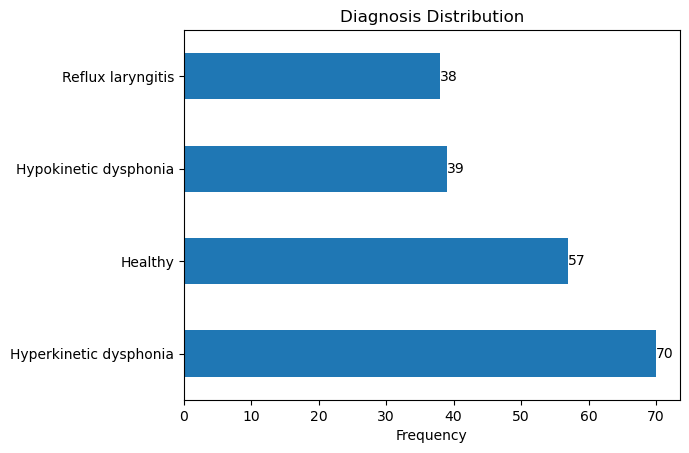

In [5]:
# Plot the distribution
diagnosis_counts = merged_df['diagnosis'].value_counts()
ax = diagnosis_counts.plot(kind='barh')

# Adjust labels
plt.title("Diagnosis Distribution")
plt.xlabel("Frequency")
plt.ylabel("")

# Update the y-tick labels
ytick_pos, ytick_labels = plt.yticks()
clean_labels = [label.get_text().capitalize() for label in ytick_labels]
plt.yticks(ytick_pos, clean_labels)

# Add the value on the bar
for index, value in enumerate(diagnosis_counts):
    ax.text(
        x = value,
        y = index,
        s = str(value),
        ha = 'left',
        va = 'center'
    )

# Display the plot
plt.show()

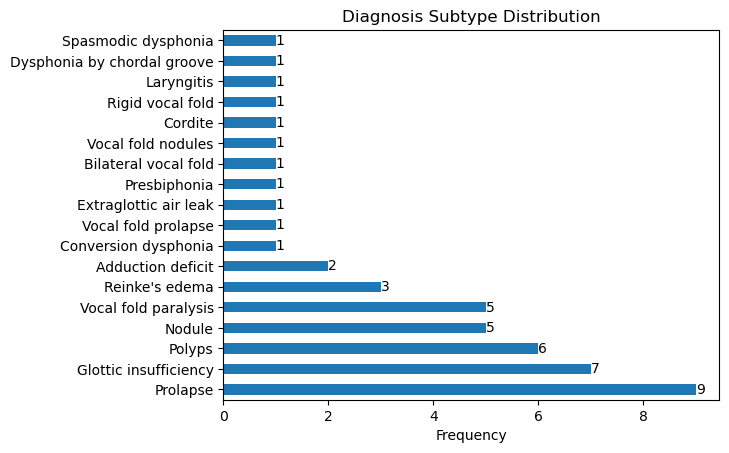

In [6]:
# Calculate the frequency of samples with a subtype
subtypes = merged_df.loc[merged_df['subtype'] != 'no subtype', 'subtype'].copy()
subtype_counts = subtypes.value_counts()

# Plot the subtype distribution
ax = subtype_counts.plot(kind='barh')

# Adjust labels
plt.title("Diagnosis Subtype Distribution")
plt.xlabel("Frequency")
plt.ylabel("")

# Update the y-tick labels
ytick_pos, ytick_labels = plt.yticks()
clean_labels = [label.get_text().capitalize() for label in ytick_labels]
plt.yticks(ytick_pos, clean_labels)

# Add the value on the bar
for index, value in enumerate(subtype_counts):
    ax.text(
        x = value,
        y = index,
        s = str(value),
        ha = 'left',
        va = 'center'
    )

# Display the plot
plt.show()

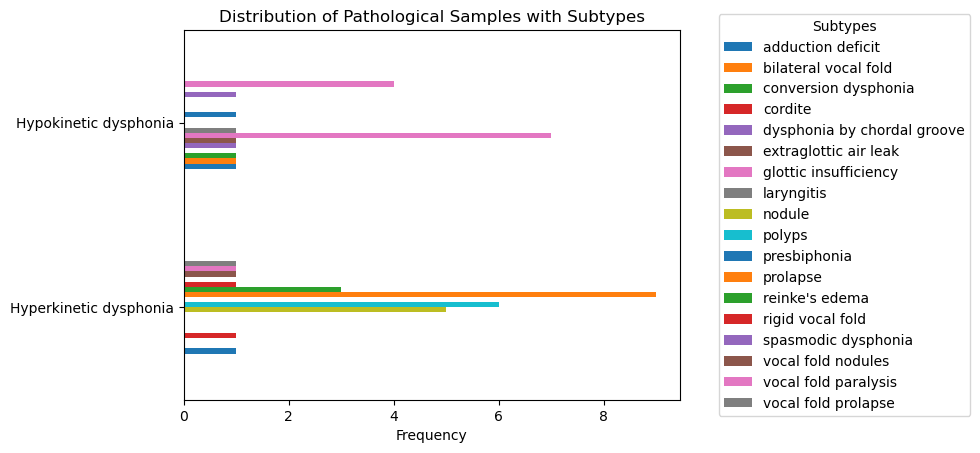

In [7]:
# Get the diagnosis and subtype of pathological samples
cols = ['diagnosis', 'subtype']
condition_1 = (merged_df['diagnosis'] != 'healthy') # pathological only
condition_2 = (merged_df['subtype'] != 'no subtype') # only with subtypes
full_diagnosis = merged_df.loc[condition_1 & condition_2, cols].copy()

# Group by diagnosis then subtype
grouped = full_diagnosis.groupby(cols).size().unstack(fill_value=0)

# Plot the grouped distribution
ax = grouped.plot(kind='barh', stacked=False)

# Add labels
plt.title("Distribution of Pathological Samples with Subtypes")
plt.xlabel("Frequency")
plt.ylabel("")

# Update the y-tick labels
ytick_pos, ytick_labels = plt.yticks()
clean_labels = [label.get_text().capitalize() for label in ytick_labels]
plt.yticks(ytick_pos, clean_labels)

# Move the legend next to the canvas
ax.legend(
    loc = 'right',
    bbox_to_anchor = (1.6,0.5),
    title = 'Subtypes'
)

# Display the plot
plt.show()

__OBSERVATION__: `Reflux Laryngitis` has no subtypes.

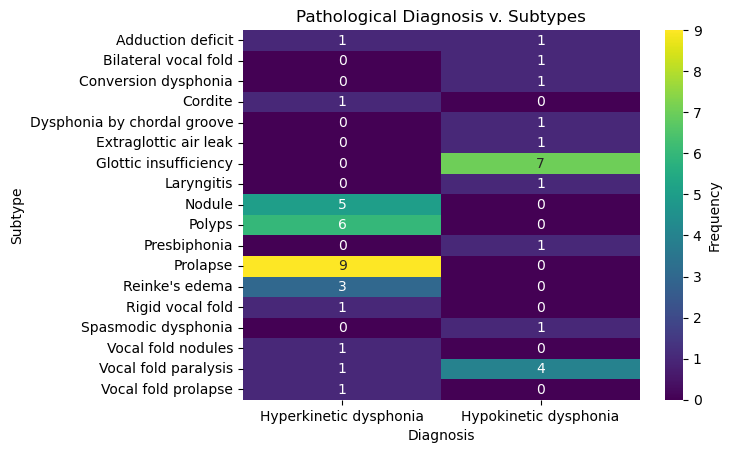

In [9]:
# Improve the previous visualisation
no_subs = ['healthy', 'reflux laryngitis']
condition_1 = (~merged_df['diagnosis'].isin(no_subs))
condition_2 = (merged_df['subtype'] != 'no subtype')

# Get the subset dataframe
full_diagnosis = merged_df.loc[condition_1 & condition_2, cols].copy()

# Group by diagnosis then subtype
grouped = full_diagnosis.groupby(cols).size().unstack(fill_value=0)

# Plot the heatmap of the distribution
hm = sns.heatmap(
    grouped.transpose(),
    annot = True,
    cmap = "viridis",
    cbar_kws = {'label': 'Frequency'}
)

# Add labels
plt.title("Pathological Diagnosis v. Subtypes")
plt.xlabel("Diagnosis")
plt.ylabel("Subtype")

# Update the tick labels
xtick_labels = hm.get_xticklabels()
ytick_labels = hm.get_yticklabels()
hm.set_xticklabels([label.get_text().capitalize() for label in xtick_labels])
hm.set_yticklabels([label.get_text().capitalize() for label in ytick_labels])

# Display the plot
plt.show()

In [10]:
merged_df['rsi_score'].describe()

count    204.000000
mean      11.848039
std        8.281468
min        0.000000
25%        5.000000
50%       12.000000
75%       18.000000
max       41.000000
Name: rsi_score, dtype: float64